Company XYZ started a subscription model in January, 2015. You get hired as a first data scientist at the end of August and, as a first task, you are asked to help executives understand how the subscription model is doing.

In [144]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

## 01. Import Data

In [145]:
df = pd.read_csv('subscription.csv')

In [146]:
df.head()

,user_id,subscription_signup_date,subscription_monthly_cost,country,source,billing_cycles,is_active
0,1459,"January, 2015",29,Spain,ads,4,0
1,12474,"January, 2015",49,France,ads,5,0
2,12294,"January, 2015",49,Germany,ads,2,0
3,3878,"January, 2015",49,China,ads,1,0
4,9567,"January, 2015",49,UK,ads,5,0


In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 7 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   user_id                    500000 non-null  int64 
 1   subscription_signup_date   500000 non-null  object
 2   subscription_monthly_cost  500000 non-null  int64 
 3   country                    500000 non-null  object
 4   source                     500000 non-null  object
 5   billing_cycles             500000 non-null  int64 
 6   is_active                  500000 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 26.7+ MB


In [148]:
df.describe()

,user_id,subscription_monthly_cost,billing_cycles,is_active
count,500000.000000,500000.000000,500000.000000,500000.000000
mean,250000.500000,48.469620,2.384970,0.099998
std,144337.711634,19.570745,2.254952,0.299998
min,1.000000,29.000000,1.000000,0.000000
25%,125000.750000,29.000000,1.000000,0.000000
50%,250000.500000,49.000000,1.000000,0.000000
75%,375000.250000,49.000000,3.000000,0.000000
max,500000.000000,99.000000,8.000000,1.000000


## 02. Data Processing

### (1) Data Clean

In [149]:
# since all subscription_signup_date are the same, we can drop it
df['subscription_signup_date'].value_counts()

January, 2015    500000
Name: subscription_signup_date, dtype: int64

In [150]:
df = df.drop(labels='subscription_signup_date',axis=1)
df.head()

,user_id,subscription_monthly_cost,country,source,billing_cycles,is_active
0,1459,29,Spain,ads,4,0
1,12474,49,France,ads,5,0
2,12294,49,Germany,ads,2,0
3,3878,49,China,ads,1,0
4,9567,49,UK,ads,5,0


## Question01
* A model that predicts monthly retention rate for the different subscription price points

In [151]:
# create a conversion rate function
def retention_rate(df):
    conversions = []
    for i in range(1,9):
        conversions.append(len(df[df['billing_cycles'] >= i])/len(df))
    return pd.Series(conversions, index=[1,2,3,4,5,6,7,8])

In [152]:
df_retention_rate = df.groupby('subscription_monthly_cost').apply(retention_rate)
df_retention_rate

,1,2,3,4,5,6,7,8
subscription_monthly_cost,,,,,,,,
29,1.0,0.607542,0.458473,0.376232,0.323028,0.285416,0.257157,0.235901
49,1.0,0.383666,0.206247,0.134043,0.096466,0.074072,0.059408,0.048845
99,1.0,0.158769,0.070040,0.042411,0.029676,0.022182,0.017937,0.015007


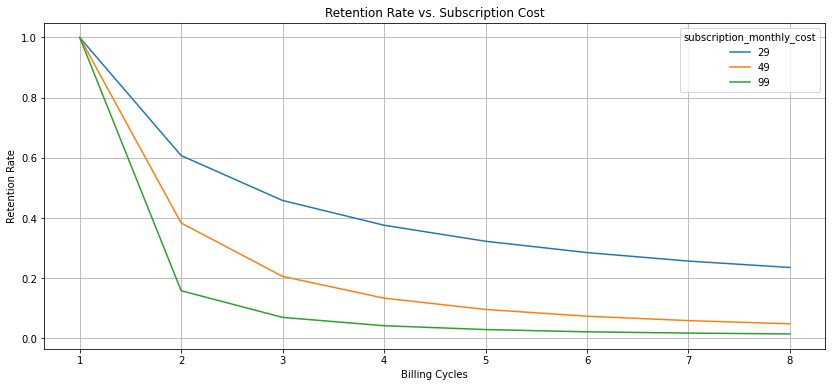

In [153]:
# plot
fig, ax = plt.subplots(figsize=(14,6))

df_retention_rate.T.plot(kind='line', ax=ax)
ax.set_title('Retention Rate vs. Subscription Cost')
ax.set_xlabel('Billing Cycles')
ax.set_ylabel('Retention Rate')
ax.grid(True)

* This is not a very big dataset, so we can use Linear Regression to make prediction
* According to above plot, we can see that the Retention Rate is not very linear. Therefore, we should add more nonlinear factors to help our Model to make accurate prediction. In this case, we can add log and square of billing cycles
* Retension rate should be non-negative, we use log(rate) to deal with it, and when we do the prediction, we transform back to it back by exp()

In [154]:
# prepare data for mdoel
df_model = pd.DataFrame()
df_model['cycles'] = df_retention_rate.columns
df_model['cycles_log'] = np.log(df_model['cycles'])
df_model['cycles_square'] = df_model['cycles']*df_model['cycles']
df_model['29_rate'] = df_retention_rate.T[29].values
df_model['49_rate'] = df_retention_rate.T[49].values
df_model['99_rate'] = df_retention_rate.T[99].values
df_model

,cycles,cycles_log,cycles_square,29_rate,49_rate,99_rate
0,1,0.000000,1,1.000000,1.000000,1.000000
1,2,0.693147,4,0.607542,0.383666,0.158769
2,3,1.098612,9,0.458473,0.206247,0.070040
3,4,1.386294,16,0.376232,0.134043,0.042411
4,5,1.609438,25,0.323028,0.096466,0.029676
5,6,1.791759,36,0.285416,0.074072,0.022182
6,7,1.945910,49,0.257157,0.059408,0.017937
7,8,2.079442,64,0.235901,0.048845,0.015007


In [155]:
# build models

lm_29 = LinearRegression()
lm_49 = LinearRegression()
lm_99 = LinearRegression()

# fit models
lm_29.fit(df_model.iloc[:,:3], np.log(df_model['29_rate']))
lm_49.fit(df_model.iloc[:,:3], np.log(df_model['49_rate']))
lm_99.fit(df_model.iloc[:,:3], np.log(df_model['99_rate']))

LinearRegression()

In [156]:
# make prediction
df_model['29_rate_pred'] = np.exp(lm_29.predict(df_model.iloc[:,:3]))
df_model['49_rate_pred'] = np.exp(lm_49.predict(df_model.iloc[:,:3]))
df_model['99_rate_pred'] = np.exp(lm_99.predict(df_model.iloc[:,:3]))

In [157]:
df_model

,cycles,cycles_log,cycles_square,29_rate,49_rate,99_rate,29_rate_pred,49_rate_pred,99_rate_pred
0,1,0.000000,1,1.000000,1.000000,1.000000,0.999502,1.003844,0.992027
1,2,0.693147,4,0.607542,0.383666,0.158769,0.608619,0.378064,0.163419
2,3,1.098612,9,0.458473,0.206247,0.070040,0.458101,0.208259,0.069098
3,4,1.386294,16,0.376232,0.134043,0.042411,0.375765,0.135129,0.041513
4,5,1.609438,25,0.323028,0.096466,0.029676,0.322898,0.096500,0.029441
5,6,1.791759,36,0.285416,0.074072,0.022182,0.285608,0.073590,0.022695
6,7,1.945910,49,0.257157,0.059408,0.017937,0.257606,0.058968,0.018197
7,8,2.079442,64,0.235901,0.048845,0.015007,0.235610,0.049174,0.014781


In [158]:
# MAE
print('MAE of $29 monthly cost: ', mean_absolute_error(df_model['29_rate'], df_model['29_rate_pred']))
print('MAE of $49 monthly cost: ', mean_absolute_error(df_model['49_rate'], df_model['49_rate_pred']))
print('MAE of $99 monthly cost: ', mean_absolute_error(df_model['99_rate'], df_model['99_rate_pred']))

MAE of $29 monthly cost:  0.0004347270380152153
MAE of $49 monthly cost:  0.0017286989106734948
MAE of $99 monthly cost:  0.0019621328744890794


* As we can see above, our MAE is very low, which means our models' predictions are very accurate

## Question02
* Based on your model, for each price point, what percentage of users is still subscribed after at least 12 months?

In [159]:
# make a new dataframe for further prediction, in this case we try to predict 9-12 months
df_model_new = pd.DataFrame()
df_model_new['cycles'] = [9,10,11,12]
df_model_new['cycles_log'] = np.log(df_model_new['cycles'])
df_model_new['cycles_square'] = df_model_new['cycles']*df_model_new['cycles']
df_model_new

,cycles,cycles_log,cycles_square
0,9,2.197225,81
1,10,2.302585,100
2,11,2.397895,121
3,12,2.484907,144


In [160]:
# build models

lm_29 = LinearRegression()
lm_49 = LinearRegression()
lm_99 = LinearRegression()

# fit models
lm_29.fit(df_model.iloc[:,:3], np.log(df_model['29_rate']))
lm_49.fit(df_model.iloc[:,:3], np.log(df_model['49_rate']))
lm_99.fit(df_model.iloc[:,:3], np.log(df_model['99_rate']))

LinearRegression()

In [161]:
# make prediction
df_model_new['29_rate_pred'] = np.exp(lm_29.predict(df_model_new.iloc[:,:3]))
df_model_new['49_rate_pred'] = np.exp(lm_49.predict(df_model_new.iloc[:,:3]))
df_model_new['99_rate_pred'] = np.exp(lm_99.predict(df_model_new.iloc[:,:3]))

In [162]:
df_model_new

,cycles,cycles_log,cycles_square,29_rate_pred,49_rate_pred,99_rate_pred
0,9,2.197225,81,0.217726,0.042412,0.011960
1,10,2.302585,100,0.202786,0.037674,0.009529
2,11,2.397895,121,0.190026,0.034361,0.007414
3,12,2.484907,144,0.178925,0.032107,0.005599


In [163]:
print('The percentage of users is still subscribed after at least 12 months in $29 month cost: ', round(df_model_new.loc[3,'29_rate_pred'],3)*100,'%')
print('The percentage of users is still subscribed after at least 12 months in $49 month cost: ', round(df_model_new.loc[3,'49_rate_pred'],3)*100,'%')
print('The percentage of users is still subscribed after at least 12 months in $99 month cost: ', round(df_model_new.loc[3,'99_rate_pred'],3)*100,'%')

The percentage of users is still subscribed after at least 12 months in $29 month cost:  17.9 %
The percentage of users is still subscribed after at least 12 months in $49 month cost:  3.2 %
The percentage of users is still subscribed after at least 12 months in $99 month cost:  0.6 %


## Question03
* How do user country and source affect subscription retention rate? How would you use these findings to improve the company revenue?

### (1) country

In [164]:
# calculate each country's retention rate
country_rate = df.groupby('country').apply(retention_rate)
country_rate

,1,2,3,4,5,6,7,8
country,,,,,,,,
China,1.0,0.514831,0.402777,0.360426,0.336274,0.319856,0.307084,0.295453
France,1.0,0.334946,0.177732,0.119004,0.088479,0.069935,0.058341,0.049688
Germany,1.0,0.451284,0.278411,0.195910,0.146474,0.115151,0.093868,0.078465
India,1.0,0.446728,0.326962,0.284527,0.261603,0.246736,0.234847,0.225769
Italy,1.0,0.341684,0.179502,0.119914,0.090015,0.071135,0.057523,0.048695
Spain,1.0,0.339098,0.178985,0.119879,0.088648,0.070065,0.057617,0.048503
UK,1.0,0.458938,0.285133,0.198067,0.149421,0.117356,0.095735,0.079494
US,1.0,0.456509,0.284255,0.198853,0.149284,0.117398,0.094875,0.078981


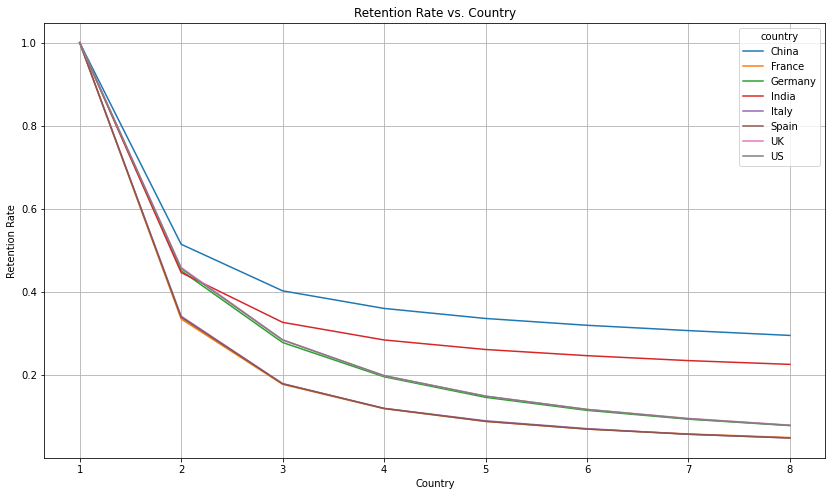

In [165]:
# plot
fig, ax = plt.subplots(figsize=(14,8))

country_rate.T.plot(kind='line', ax=ax)
ax.set_title('Retention Rate vs. Country')
ax.set_xlabel('Country')
ax.set_ylabel('Retention Rate')
ax.grid(True)

plt.show()

### (2) source

In [166]:
# calculate each country's retention rate
source_rate = df.groupby('source').apply(retention_rate)
source_rate

,1,2,3,4,5,6,7,8
source,,,,,,,,
ads,1.0,0.388873,0.222094,0.152607,0.114959,0.092043,0.076756,0.066237
friend_referral,1.0,0.699443,0.617038,0.561282,0.519854,0.487596,0.461110,0.436507
seo,1.0,0.562395,0.420012,0.337594,0.286254,0.247877,0.218680,0.194475


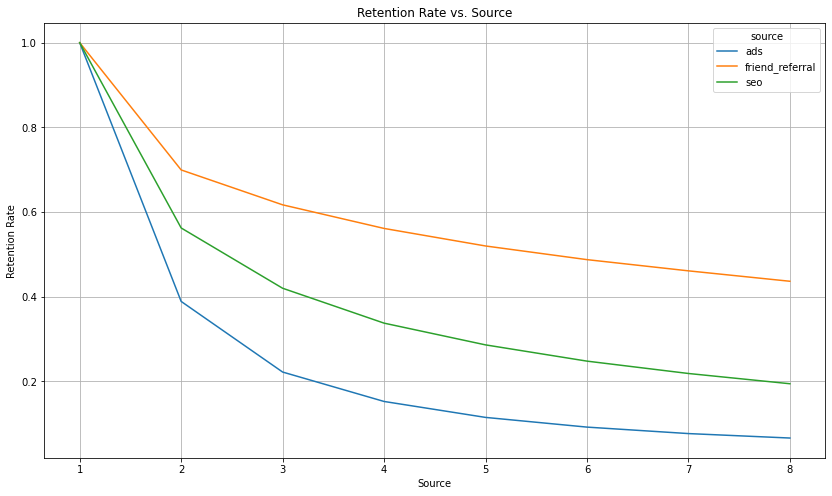

In [167]:
# plot
fig, ax = plt.subplots(figsize=(14,8))

source_rate.T.plot(kind='line', ax=ax)
ax.set_title('Retention Rate vs. Source')
ax.set_xlabel('Source')
ax.set_ylabel('Retention Rate')
ax.grid(True)

plt.show()

* **China** and **India** have higher retention rate. Due to the large population of both countries, our marketing team should increase the exposure of our products, more advertising and promotional activities
* **France**, **Italy**, and **Spain** have very low retention rate, we should try to figure out the reasons. Maybe there is a very strong competitor in these three countries because their location are very close.
* For source, if the users start subscribing our services by **friend referral**, their retention rate is very high. Therefore, we should send some recommended Discount coupons to old users, encouraging them to bring more friends to our sit to subscribe our services.